## Background

Twitter has become a wildly sprawling jungle of information. Somewhere between 350 million and 500 million tweets are estimated to be sent out per day. With such an explosion of data, on Twitter and elsewhere, it becomes more important than ever to tame it in some way, to concisely capture the essence of the data.

## Method

Python script to perform a sentiment analysis of the Twitter activity of various news oulets, and to present some findings visually.

The final output provides a visualized summary of the sentiments expressed in Tweets sent out by the following news organizations: BBC, CBS, CNN, Fox, and New York times.

In [1]:
# Import needy libraries and API Key

import tweepy
import json
from twitter__api import (api_key, api_secret, access_token, access_token_secret)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

# Import VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
# Media Sources
target_users = ("BBC", "CBS", "CNN", "FoxNews", "nytimes")

In [3]:
# Set Up Appropirate Dictionary and Lists
sentiments ={}

# Loop through Media Soruces 
for target in target_users:

    # Set up empty lists to append
    dates = []
    texts = []
    sources = []
    compound = []
    positive = []
    negative = []
    neutral = []
    tweet_ago = []
    
    # Set up the counter
    counter = 0
    
    # Loop 5x20 tweets for each Media 
    for x in range(5):
        
        # Read the API for Media Sources
        public_tweets = api.user_timeline(target, page = x)
        
        for tweet in public_tweets:
                       
            
            # print(json.dumps(tweet, indent = 4, sort_keys = True))
            
            # Append empty lists 
            dates.append(tweet['created_at'])
            texts.append(tweet['text'])
            sources.append(tweet['source'])
            
            
            results = analyzer.polarity_scores(tweet["text"])
            com = results["compound"]
            pos = results["pos"]
            neg = results["neg"]
            neu = results["neu"]
            
            compound.append(com)
            positive.append(pos)
            negative.append(neg)
            neutral.append(neu)
            
            counter += 1
            tweet_ago.append(counter)
    
    # Fill in Sentiments dictionary
    sentiments[target]=(tweet_ago, dates, texts, sources, compound, positive, negative, neutral)

In [4]:
# Define a function to hold values from Sentiments dictionary 

def news(target):
    the_data = {'Tweet Ago': sentiments[target][0],
           'Date': sentiments[target][1],
           'Text': sentiments[target][2],
           'Source': sentiments[target][3],
           'Compound': sentiments[target][4],
           'Positive': sentiments[target][5],
           'Negative': sentiments[target][6],
           'Neutral': sentiments[target][7],
            'Target': target, 
               }
    return(pd.DataFrame(the_data))

In [5]:
# Set up Sentiments dictionary columns 
columns = ['Target', 'Tweet Ago', 'Date', 'Compound', 'Positive', 'Negative', 'Neutral', 'Text', 'Source']

sentiments_clean = pd.DataFrame(columns = columns)

In [6]:
# Loop through each Media Sources 
for target in target_users:
    sentiments_clean = sentiments_clean.append(news(target))

In [7]:
# Convert the timestamps

sentiments_clean['Date'] = pd.to_datetime(sentiments_clean['Date'])

In [8]:
# Re-arrange sentiments column and assing it to a new Data Frame

sentiments_clean = pd.DataFrame(sentiments_clean, columns = ['Target', 'Date', 'Tweet Ago', 'Compound', 'Positive', 'Negative', 'Neutral', 
                                              'Text', 'Source'])
select_data = sentiments_clean

In [9]:
# Split each Media Sources to generate seperate Data Frames

data_BBC = select_data.loc[select_data['Target'] == 'BBC']
data_CBS = select_data.loc[select_data['Target'] == 'CBS']
data_CNN = select_data.loc[select_data['Target'] == 'CNN']
data_FoxNews = select_data.loc[select_data['Target'] == 'FoxNews']
data_nytimes = select_data.loc[select_data['Target'] == 'nytimes']

In [10]:
# Concatinate each Data Frames 

frames = [data_BBC, data_CBS, data_CNN, data_FoxNews, data_nytimes]
big_data = pd.concat(frames)
big_data.to_csv('SentimentAnalysisData.csv')

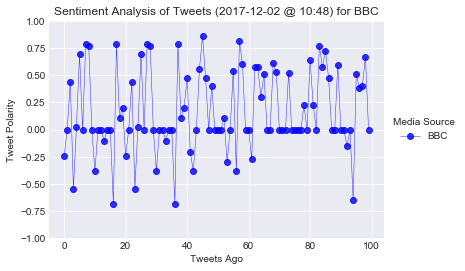

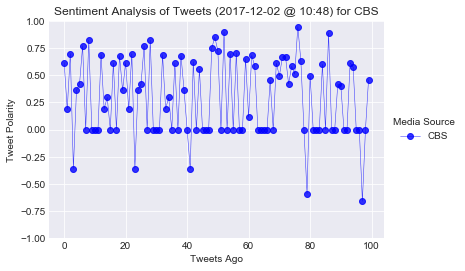

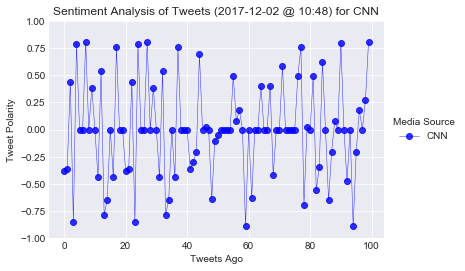

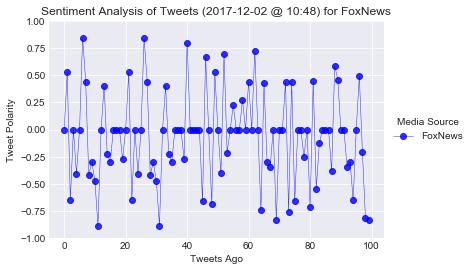

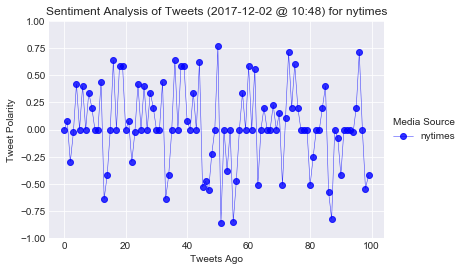

In [14]:
# Loop each Media Sources to Plot individually 

for target in target_users:
    
    name_news = select_data.loc[select_data['Target'] == target]
        
        # print(name_news['Compound'])
        
    plt.plot(np.arange(len(data_BBC['Compound'])),
            name_news['Compound'], marker = 'o', linewidth = 0.5,
            alpha = 0.8, color = 'b', label = target)
        
    now = datetime.now()
    now = now.strftime("%Y-%m-%d @ %H:%M")
    plt.title("Sentiment Analysis of Tweets ({}) for {}".format(now, target))
    plt.ylabel("Tweet Polarity")
    plt.xlabel("Tweets Ago")
    plt.ylim(-1, 1)
    art = []
    plt.style.use('seaborn-darkgrid')
    plt.legend(title= 'Media Source', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(f"SentimentAnalysisFor{target}", additional_artists=art, bbox_inches="tight")
    plt.show()

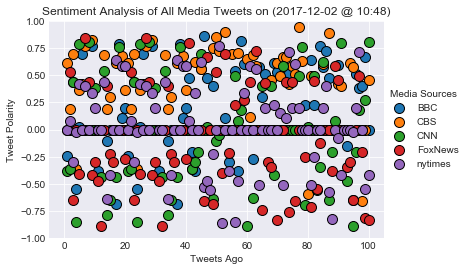

In [12]:
# Make a plot of all Media Sources together

compound_news = big_data.pivot(index='Tweet Ago', columns='Target', values='Compound')
compound_news.plot(marker = 'o', grid= True, style = ' ', ms = 10, markeredgecolor= 'black')

now = datetime.now()
now = now.strftime("%Y-%m-%d @ %H:%M")
plt.title('Sentiment Analysis of All Media Tweets on ({})'.format(now))
plt.ylabel('Tweet Polarity')
plt.xlabel('Tweets Ago')

plt.ylim(-1, 1)
plt.xlim(-5, 105)
plt.legend(title = 'Media Sources', bbox_to_anchor=(1, 0.5), loc='center left', borderaxespad=0.1)

plt.savefig(f"SentimentAnalysisAllMediaTweets", additional_artists=art, bbox_inches="tight")
plt.show()

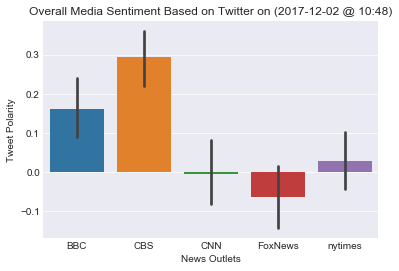

In [13]:
# Make a bar plot of Compund Data of Media Sources together

sns.barplot(x='Target', y='Compound', data = big_data)

now = datetime.now()
now = now.strftime("%Y-%m-%d @ %H:%M")
plt.title('Overall Media Sentiment Based on Twitter on ({})'.format(now))

plt.ylabel('Tweet Polarity')
plt.xlabel('News Outlets')
plt.savefig(f"MediaSentimentsBarplot", additional_artists=art, bbox_inches="tight")
plt.show()